# Load dataset

To download image data for modeling using the same data from GitHub repository  https://github.com/gigascience/paper-bray2017/tree/master. The number of plates to be used for training was reduced down to 4 plates as each plate of images take up a lot of disk storage space. The downloaded files were compressed into .zip files so unzippig the files are needed in order to preprocess the images.

In [ ]:
# import os
# from concurrent.futures import ThreadPoolExecutor
# import requests
# from tqdm.notebook import tqdm

# # Base URL and parameters
# base_url = "https://cildata.crbs.ucsd.edu/broad_data/plate_{plate}/{plate}-{channel}.zip"
# # Add plate numbers here...
# plates = [
#     24277, 24278, 24279, 24280
#     # 24293, 24294, 24295, 24296, 24297, 24300, 24301, 24302, 24303, 24304, 24305, 24306,
#     # 24307, 24308, 24309, 24310, 24311, 24312, 24313, 24319, 24320, 24321, 24352, 24357, 24507, 24508, 24509, 24512,
#     # 26772, 26785, 26786, 26794, 26795
# ]
# channels = ["Hoechst", "ERSyto", "ERSytoBleed", "Ph_golgi", "Mito"]

# # Download directory
# download_dir = "/content/cil_images"
# os.makedirs(download_dir, exist_ok=True)

# # Function to download a single file
# def download_file(url, output_dir):
#     local_filename = os.path.join(output_dir, url.split("/")[-1])
#     try:
#         response = requests.get(url, stream=True)
#         response.raise_for_status()
#         with open(local_filename, 'wb') as f:
#             for chunk in response.iter_content(chunk_size=8192):
#                 f.write(chunk)
#     except requests.exceptions.RequestException as e:
#         print(f"Failed to download {url}: {e}")

# # Generate list of URLs
# url_list = [base_url.format(plate=plate, channel=channel) for plate in plates for channel in channels]

# # Download files using multithreading
# with ThreadPoolExecutor(max_workers=8) as executor:
#     list(tqdm(executor.map(lambda url: download_file(url, download_dir), url_list), total=len(url_list), desc="Downloading"))

# print("Download completed. Files are saved in:", download_dir)


In [ ]:
# # Extract the datasets
# import zipfile
# from tqdm.notebook import tqdm

# # Create an output directory for unzipped files
# unzip_dir = "/content/unzipped_data"
# os.makedirs(unzip_dir, exist_ok=True)

# # Get the list of all .zip files in the directory
# zip_files = [f for f in os.listdir(download_dir) if f.endswith(".zip")]

# # Unzip each file
# for zip_file in tqdm(zip_files, desc="Unzipping files"):
#     zip_path = os.path.join(download_dir, zip_file)
#     try:
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(unzip_dir)
#     except zipfile.BadZipFile:
#         print(f"Error: {zip_file} is not a valid zip file")

# print("Unzipping completed. Extracted files are saved in:", unzip_dir)

# **Explore Data with API**

In [ ]:
import numpy as np
import pandas as pd
import random
import cv2
import glob
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from PIL import Image
from io import BytesIO
import requests
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#generic api key to access data
import requests

INDEX_PAGE = "https://idr.openmicroscopy.org/webclient/?experimenter=-1"

# create http session
with requests.Session() as session:
    request = requests.Request('GET', INDEX_PAGE)
    prepped = session.prepare_request(request)
    response = session.send(prepped)
    if response.status_code != 200:
        response.raise_for_status()

screen_id = 1251

MAP_URL = "https://idr.openmicroscopy.org/webclient/api/annotations/?type=map&{type}={screen_id}"

qs = {'type': 'screen', 'screen_id': screen_id}
url = MAP_URL.format(**qs)
for a in session.get(url).json()['annotations']:
    namespace = a['ns']
    for v in a['values']:
        key = v[0]
        value = v[1]
        print (key, value)

PLATES_URL = "https://idr.openmicroscopy.org/webclient/api/plates/?id={screen_id}"

qs = {'screen_id': screen_id}
url = PLATES_URL.format(**qs)
for p in session.get(url).json()['plates']:
    plate_id = p['id']
    print (p['id'], p['name'], p['childCount'])

WELLS_IMAGES_URL = "https://idr.openmicroscopy.org/webgateway/plate/{plate_id}/{field}/"

qs = {'plate_id': plate_id, 'field': 0}
url = WELLS_IMAGES_URL.format(**qs)
grid = session.get(url).json()
rowlabels = grid['rowlabels']
collabels = grid['collabels']
for row in grid['grid']:
    for cell in row:
        if cell is not None:
            well_id = cell['wellId']
            image_id = cell['id']
            thumb_url = cell['thumb_url']
            field = cell['field']
            print (cell['wellId'], cell['id'], cell['thumb_url'], cell['field'])

qs = {'image_id': image_id}
IMAGE_DETAILS_URL = "https://idr.openmicroscopy.org/webclient/imgData/{image_id}/"
url = IMAGE_DETAILS_URL.format(**qs)
r = session.get(url)
if r.status_code == 200:
    print (r.json())

MAP_URL = "https://idr.openmicroscopy.org/webclient/api/annotations/?type=map&{type}={image_id}"

qs = {'type': 'image', 'image_id': image_id}
url = MAP_URL.format(**qs)
for a in session.get(url).json()['annotations']:
    namespace = a['ns']
    for v in a['values']:
        key = v[0]
        value = v[1]
        print (key, value)

Sample Type cell
Organism Homo sapiens
Study Title Human U2OS cells - compound cell-painting experiment
Study Type high content screen
Screen Type primary screen
Screen Technology Type compound screen
Imaging Method fluorescence microscopy
Publication Title Toward performance-diverse small-molecule libraries for cell-based phenotypic screening using multiplexed high-dimensional profiling.
Publication Authors Wawer MJ, Li K, Gustafsdottir SM, Ljosa V, Bodycombe NE, Marton MA, Sokolnicki KL, Bray MA, Kemp MM, Winchester E, Taylor B, Grant GB, Hon CS, Duvall JR, Wilson JA, Bittker JA, Dančík V, Narayan R, Subramanian A, Winckler W, Golub TR, Carpenter AE, Shamji AF, Schreiber SL, Clemons PA
PubMed ID 25024206 https://www.ncbi.nlm.nih.gov/pubmed/25024206
PMC ID PMC4121832 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4121832
Publication DOI 10.1073/pnas.1410933111 https://doi.org/10.1073/pnas.1410933111
Publication Title A dataset of images and morphological profiles of 30 000 small-molecul

In [ ]:
# #process images from api
# def fetch_images(plate_id, session):
#     images = []
#     BASE_URL = "https://idr.openmicroscopy.org"
#     for FIELD in range(1, 7):
#         WELLS_IMAGES_URL = f"{BASE_URL}/webgateway/plate/{plate_id}/{FIELD}/"

#         try:
#             response = session.get(WELLS_IMAGES_URL)
#             response.raise_for_status()
#             grid = response.json()

#             for row in grid['grid']:
#                 for cell in row:
#                     if cell is not None:
#                         thumb_url = BASE_URL + cell['thumb_url']
#                         try:
#                             image_response = session.get(thumb_url)
#                             image_response.raise_for_status()
#                             img = Image.open(BytesIO(image_response.content))
#                             image_array = np.array(img)

#                             images.append({
#                                 "Plate ID": plate_id,
#                                 "Image Name": cell['name'],
#                                 "Image Array": image_array,
#                             })

#                         except Exception as e:
#                             print(f"Error processing image {cell.get('name', 'Unknown')} "
#                                   f"from plate {plate_id}, field {FIELD}: {e}")
#         except Exception as e:
#             print(f"Error fetching images for plate {plate_id}, field {FIELD}: {e}")

#     return images

# #run the functions on selected plate_ids
# with requests.Session() as session:
#     plate_ids = [6208, 4907, 4906]
#     all_images = []
#     for plate_id in plate_ids:
#         all_images.extend(fetch_images(plate_id, session))

# image_data = pd.DataFrame(all_images)

# from sklearn.preprocessing import MinMaxScaler

# # To extract individual channels from the RGB image
# def extract_channels(image_array):
#     red_channel = image_array[:, :, 0] # Red channel: ERSyto
#     green_channel = image_array[:, :, 1] # Green channel: ERSytoBleed
#     blue_channel = image_array[:, :, 2] # Blue channel: Hoechst

#     return red_channel, green_channel, blue_channel

# # Normalize a single channel
# def normalize_channel(channel):
#     channel = channel.astype("float32")
#     max_val = channel.max()

#     if max_val == 0:
#         return channel

#     return channel / max_val

# # Calculate average brightness of a channel
# def calculate_brightness(channel):
#     return channel.mean()

# from skimage.restoration import rolling_ball
# from skimage.filters import threshold_otsu
# from skimage.exposure import equalize_hist

# # Subtract background to reduce overlaps between the channels and enhance the distinct channel from each marker
# def subtract_background(channel, radius=0.05):
#     return rolling_ball(channel, radius=radius)

# # Normalize each channel to its maximum intensity
# def normalize_channel_by_max(channel):
#     # Replace NaN values with 0s
#     if np.isnan(channel).any():
#         channel = np.nan_to_num(channel, nan=0.0)

#     # Avoid dividing by 0
#     if channel.max() == 0:
#         return np.zeros_like(channel)

#     return channel / channel.max()

# # Apply threshold to isolate the fluorescence intensity values
# def apply_threshold(channel):
#     threshold = threshold_otsu(channel)

#     return (channel > threshold).astype(float)

# # Improve contrast for each channel
# def enhance_contrast(channel):
#     return equalize_hist(channel)

# # Image processing steps
# def process_image(image_array, plate_id, image_name):
#     red_channel, green_channel, blue_channel = extract_channels(image_array)

#     # Apply background subtraction
#     red_bg_subtracted = subtract_background(red_channel)
#     green_bg_subtracted = subtract_background(green_channel)
#     blue_bg_subtracted = subtract_background(blue_channel)

#     # To normalize the channels
#     red_normalized = normalize_channel_by_max(red_bg_subtracted)
#     green_normalized = normalize_channel_by_max(green_bg_subtracted)
#     blue_normalized = normalize_channel_by_max(blue_bg_subtracted)

#     # Enhance contrast with adaptive histogram equalization
#     red_contrast = enhance_contrast(red_normalized)
#     green_contrast = enhance_contrast(green_normalized)
#     blue_contrast = enhance_contrast(blue_normalized)

#     # Calculate average brightness
#     red_brightness = calculate_brightness(red_normalized)
#     green_brightness = calculate_brightness(green_normalized)
#     blue_brightness = calculate_brightness(blue_normalized)

#     # Apply threshold
#     red_threshold = apply_threshold(red_normalized)
#     green_threshold = apply_threshold(green_normalized)
#     blue_threshold = apply_threshold(blue_normalized)

#     # Enhance contrasts
#     red_contrast = enhance_contrast(red_threshold)
#     green_contrast = enhance_contrast(green_threshold)
#     blue_contrast = enhance_contrast(blue_threshold)

#     return {
#         "Plate ID": plate_id,
#         "Image Name": image_name,
#         "Image Array": image_array,
#         "Red Channel": red_contrast,
#         "Green Channel": green_contrast,
#         "Blue Channel": blue_contrast,
#         "Red Brightness": red_brightness,
#         "Green Brightness": green_brightness,
#         "Blue Brightness": blue_brightness,
#     }

# # Apply processing to images
# processed_images = []

# for _, row in image_data_df.iterrows():
#     image_array = row['Image Array']
#     processed_data = process_image(image_array, row['Plate ID'], row['Image Name'])
#     processed_images.append(processed_data)


# image_data = pd.DataFrame(processed_images)

# # To visualize individual channels for a sample image
# def visualize_image(image_array, image_name, red_channel, green_channel, blue_channel):
#     plt.figure(figsize=(15, 6))

#     plt.subplot(1, 4, 1)
#     plt.imshow(image_array)
#     plt.title(f"RGB Image: {image_name}")
#     plt.axis('off')

#     plt.subplot(1, 4, 2)
#     plt.title("Red Channel (ERSyto)")
#     plt.imshow(red_channel, cmap='Reds')
#     plt.axis('off')

#     plt.subplot(1, 4, 3)
#     plt.title("Green Channel (ERSytoBleed)")
#     plt.imshow(green_channel, cmap='Greens')
#     plt.axis('off')

#     plt.subplot(1, 4, 4)
#     plt.title("Blue Channel (Hoechst)")
#     plt.imshow(blue_channel, cmap="Blues")
#     plt.axis('off')

#     plt.tight_layout()
#     plt.show()

# sample = image_data.iloc[0]
# visualize_image(
#     sample['Image Array'],
#     sample['Image Name'],
#     sample['Red Channel'],
#     sample['Green Channel'],
#     sample['Blue Channel']
# )

In [ ]:
#functions to load images to image_data_df

image_data_df = pd.DataFrame(columns=["Plate ID", "Image Name", "Red Brightness", "Green Brightness", "Blue Brightness", "Image Array"])

#calculates the average brightness for each RGB channel in each image
def calculate_channel_brightness(image_array):
    """Calculate the average brightness for each RGB channel"""
    r, g, b = image_array[:, :, 0], image_array[:, :, 1], image_array[:, :, 2]
    return np.mean(r), np.mean(g), np.mean(b)

#process images from api
def fetch_images_and_brightness(plate_id, session):
    BASE_URL = "https://idr.openmicroscopy.org"
    for FIELD in range(1, 7):
        WELLS_IMAGES_URL = f"{BASE_URL}/webgateway/plate/{plate_id}/{FIELD}/"

        try:
            response = session.get(WELLS_IMAGES_URL)
            response.raise_for_status()
            grid = response.json()

            for row in grid['grid']:
                for cell in row:
                    if cell is not None:
                      #parse the thumbnail for each image
                        thumb_url = BASE_URL + cell['thumb_url']
                        try:
                            image_response = session.get(thumb_url)
                            image_response.raise_for_status()
                            img = Image.open(BytesIO(image_response.content))
                            image_array = np.array(img)

                            #calculate brightness for each channel
                            red, green, blue = calculate_channel_brightness(image_array)

                            #store data in a df
                            image_data_df.loc[len(image_data_df)] = {
                                "Plate ID": plate_id,
                                "Image Name": cell['name'],
                                "Field": FIELD,
                                "Red Brightness": red,
                                "Green Brightness": green,
                                "Blue Brightness": blue,
                                "Image Array": image_array,
                            }
                        except Exception as e:
                            print(f"Error processing image {cell.get('name', 'Unknown')} "
                                  f"from plate {plate_id}, field {FIELD}: {e}")
        except Exception as e:
            print(f"Error fetching images for plate {plate_id}, field {FIELD}: {e}")

#run the functions on selected plate_ids
with requests.Session() as session:
    plate_ids = [6208, 4907, 4906, 6151, 6210]
    for plate_id in plate_ids:
        fetch_images_and_brightness(plate_id, session)




In [ ]:
image_data_df['Total Brightness'] = image_data_df['Red Brightness'] + image_data_df['Green Brightness'] + image_data_df['Blue Brightness']

In [ ]:
image_data_df.head()

,Plate ID,Image Name,Red Brightness,Green Brightness,Blue Brightness,Image Array,Total Brightness
0,6208,"24277 [Well A1, Field 2]",30.582893,28.410065,14.621919,"[[[17, 12, 6], [17, 12, 6], [20, 17, 8], [26, ...",73.614877
1,6208,"24277 [Well A2, Field 2]",54.596978,36.532570,20.970217,"[[[34, 17, 0], [31, 12, 0], [37, 12, 7], [53, ...",112.099765
2,6208,"24277 [Well A3, Field 2]",38.505135,41.843016,15.798415,"[[[0, 31, 0], [7, 38, 7], [23, 47, 34], [34, 5...",96.146567
3,6208,"24277 [Well A4, Field 2]",22.289466,26.241491,14.119425,"[[[80, 24, 25], [98, 47, 46], [69, 28, 24], [3...",62.650381
4,6208,"24277 [Well A5, Field 2]",20.238263,24.889965,22.041520,"[[[5, 8, 0], [6, 10, 0], [3, 13, 2], [3, 15, 1...",67.169748


In [ ]:
#create new columns called Plate and Well that will match up with the chemical annotations data to merge dataframes
image_data_df["Plate"] = image_data_df["Image Name"].str.extract(r"(\d{5})")
image_data_df["Well"] = image_data_df["Image Name"].str.extract(r"\[Well (.+?),")

In [ ]:
#convert 'Plate' to numeric so that it matches with well_annotations for merge
image_data_df['Plate'] = pd.to_numeric(image_data_df['Plate'], errors='coerce')

In [ ]:
well_annotations = pd.read_csv('/content/idr0016-screenA-annotation.csv')

<ipython-input-9-3a210d8f5629>:1: DtypeWarning: Columns (15,22) have mixed types. Specify dtype option on import or set low_memory=False.
  well_annotations = pd.read_csv('/content/idr0016-screenA-annotation.csv')


In [ ]:
#merge image df and compound df
merged_df = pd.merge(
    image_data_df,
    well_annotations,
    how="left",
    on=["Plate", "Well"]
)

In [ ]:
#extract negative control wells from merged_df
negative_control_data = merged_df[merged_df['Control Type'] == 'negative control']

#create min and max brightness for red channel
mean_red_brightness = negative_control_data['Red Brightness'].mean()
std_red_brightness = negative_control_data['Red Brightness'].std()
red_min = mean_red_brightness - std_red_brightness
red_max = mean_red_brightness + std_red_brightness
#create min and max brightness for blue channel
mean_blue_brightness = negative_control_data['Blue Brightness'].mean()
std_blue_brightness = negative_control_data['Blue Brightness'].std()
blue_min = mean_blue_brightness - std_blue_brightness
blue_max = mean_blue_brightness + std_blue_brightness
#create min and max brightness for green channel
mean_green_brightness = negative_control_data['Green Brightness'].mean()
std_green_brightness = negative_control_data['Green Brightness'].std()
green_min = mean_green_brightness - std_green_brightness
green_max = mean_green_brightness + std_green_brightness

#create min and max total brightness
mean_brightness = negative_control_data['Total Brightness'].mean()
std_brightness = negative_control_data['Total Brightness'].std()
total_min = mean_brightness - std_brightness
total_max = mean_brightness + std_brightness


In [ ]:
#functions to create image labels
#compares brightness of rgb channels in image to min and max brightness
#labels each channel as either increase, decrease, or no_change in protein expression
def label_red_change(row):
    if row['Red Brightness'] < red_min:
        return -(red_min - row['Red Brightness'])
    elif row['Red Brightness'] > red_max:
        return row['Red Brightness'] - red_max
    else:
        return 0

def label_blue_change(row):
    if row['Blue Brightness'] < blue_min:
        return -(blue_min - row['Blue Brightness'])
    elif row['Blue Brightness'] > blue_max:
        return row['Blue Brightness'] - blue_max
    else:
        return 0

def label_green_change(row):
    if row['Green Brightness'] < green_min:
        return -(green_min - row['Green Brightness'])
    elif row['Green Brightness'] > green_max:
        return row['Green Brightness'] - green_max
    else:
        return 0

def label_total_change(row):
    if row['Total Brightness'] < total_min:
        return -(total_min - row['Total Brightness'])
    elif row['Total Brightness'] > total_max:
        return row['Total Brightness'] - total_max
    else:
        return 0


In [ ]:
#apply labels to merged_df to show difference in protein transcription for each channel
merged_df['red_change'] = merged_df.apply(label_red_change, axis=1)
merged_df['blue_change'] = merged_df.apply(label_blue_change, axis=1)
merged_df['green_change'] = merged_df.apply(label_green_change, axis=1)
merged_df['total_change'] = merged_df.apply(label_total_change, axis=1)

In [ ]:
#add new feature to analyze if change in protein transcription is positive or negative
merged_df['red_sign'] = merged_df['red_change'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'no_change')
merged_df['blue_sign'] = merged_df['blue_change'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'no_change')
merged_df['green_sign'] = merged_df['green_change'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'no_change')
merged_df['total_sign'] = merged_df['total_change'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'no_change')

In [ ]:
#scale changes in protein transcription between zero and one for consistency
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler to scale brightness values to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))

# Select RGB brightness columns
change_columns = ['red_change', 'green_change', 'blue_change', 'total_change']

# Fit and transform brightness values
merged_df[['red_change', 'green_change', 'blue_change', 'total_change']] = scaler.fit_transform(
    merged_df[change_columns]
)

# Verify normalization
print(merged_df[['red_change', 'green_change', 'blue_change', 'total_change']].head())

   red_change  green_change  blue_change  total_change
0    0.416206      0.373624     0.108276      0.337408
1    0.673797      0.444334     0.108276      0.366225
2    0.416206      0.444334     0.108276      0.359919
3    0.337152      0.340981     0.108276      0.279087
4    0.299997      0.320637     0.108276      0.303126


In [ ]:
average_changes = merged_df.groupby('Compound Name')[['red_change', 'blue_change', 'green_change', 'total_change']].mean()

from IPython.display import display, HTML

# Assuming average_changes is your DataFrame containing the average change columns
display(HTML(average_changes.to_html(max_rows=30)))

,red_change,blue_change,green_change,total_change
Compound Name,,,,
"( R)-(+)-WIN 55,212-2 mesylate[(R)-(+)-[2,3-Dihydro-5-methyl-3[(morpholinyl)methyl]pyrrolo[1,2,3-de]-1,4-benzoxazinyl]-(]",0.268038,0.085320,0.286862,0.228915
(+)-isocorydine,0.488109,0.109125,0.444334,0.369400
"(-)-[3R,4S]-Chromanol 293B",0.502484,0.108276,0.452203,0.383556
(3Z)-3-Benzylidene-4-oxopentanoic acid,0.416206,0.108831,0.444334,0.359919
(R)-angolensin,0.418762,0.112745,0.460149,0.364213
(S)-(+)-Dimethindene maleate,0.431055,0.109722,0.457046,0.362256
(S)-(-)-Pindolol,0.416380,0.110986,0.455537,0.362095
"1,3,5-trimethoxybenzene",0.415347,0.108159,0.454825,0.357971
"1,5-isoquinolinediol",0.419428,0.112090,0.455163,0.365139


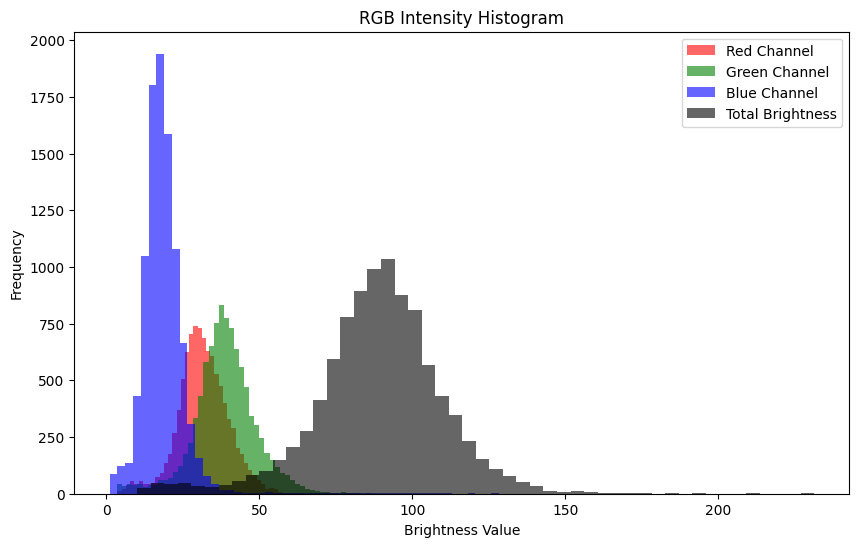

In [ ]:
# Extract RGB brightness values
red_brightness = merged_df['Red Brightness']
green_brightness = merged_df['Green Brightness']
blue_brightness = merged_df['Blue Brightness']
total_brightness = merged_df['Total Brightness']

# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(red_brightness, bins=50, alpha=0.6, label='Red Channel', color='red')
plt.hist(green_brightness, bins=50, alpha=0.6, label='Green Channel', color='green')
plt.hist(blue_brightness, bins=50, alpha=0.6, label='Blue Channel', color='blue')
plt.hist(total_brightness, bins=50, alpha=0.6, label='Total Brightness', color='black')

plt.title('RGB Intensity Histogram')
plt.xlabel('Brightness Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# **CNN Model**

In [ ]:
# Separate negative control images
negative_control_df = merged_df[merged_df['Control Type'] == 'negative control']
experimental_df = merged_df



In [ ]:


# Initialize lists to store labels
labels = []
negative_labels = []

# Assign label 1 for all rows in the experimental dataframe
labels = [1] * len(experimental_df)

# Assign label 0 for all rows in the negative control dataframe
negative_labels = [0] * len(negative_control_df)

# If you want to add these labels as new columns in your DataFrame:
experimental_df['total_change_label'] = labels
negative_control_df['total_change_label'] = negative_labels



<ipython-input-19-95a44b7f4f09>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_control_df['total_change_label'] = negative_labels


In [ ]:
# Extract images
negative_image_arrays = np.stack(negative_control_df['Image Array'].values)
experimental_image_arrays = np.stack(experimental_df['Image Array'].values)

# Normalize images
negative_image_arrays = negative_image_arrays.astype('float32') / 255.0
experimental_image_arrays = experimental_image_arrays.astype('float32') / 255.0

# Convert images to grayscale by averaging the channels (R, G, B)
def rgb_to_grayscale(images):
    return np.mean(images, axis=-1, keepdims=True)

# Convert the images in both datasets to grayscale
grayscale_negative_images = rgb_to_grayscale(negative_image_arrays)
grayscale_experimental_images = rgb_to_grayscale(experimental_image_arrays)

# Resize images to 128x128
resized_negative_images = np.array([
    tf.image.resize(img, (128, 128)).numpy() for img in grayscale_negative_images
])
resized_experimental_images = np.array([
    tf.image.resize(img, (128, 128)).numpy() for img in grayscale_experimental_images
])



In [ ]:
# split data into test and train set
x_train, x_test, y_train, y_test = train_test_split(
    resized_negative_images, negative_labels, test_size=0.2, random_state=42
)

In [ ]:
x_experimental = resized_experimental_images
experimental_labels = np.array(labels)


In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Define the Autoencoder model function
def build_ae(input_shape, latent_dim):
    # Encoder
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)

    # Latent space
    latent_vector = layers.Dense(latent_dim, name="latent_vector")(x)

    # Decoder
    latent_inputs = layers.Input(shape=(latent_dim,), name="decoder_input")
    x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((32, 32, 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x)
    outputs = layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x)

    # Define encoder and decoder models
    encoder = models.Model(inputs, latent_vector, name="encoder")
    decoder = models.Model(latent_inputs, outputs, name="decoder")

    # AE model (linking encoder and decoder)
    outputs = decoder(encoder(inputs))
    ae = models.Model(inputs, outputs, name="autoencoder")

    # Compile the model
    ae.compile(optimizer="adam", loss="mse")
    return ae

# Initialize the AE model with grayscale input and 2D latent space
latent_dim = 2
ae = build_ae(input_shape=(128, 128, 1), latent_dim=latent_dim)

x_train = x_train.astype("float32") / 255.0

# Train the model
ae.fit(x_train, x_train, epochs=20, batch_size=32)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 0.1905
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 3.2367e-07
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 3.2562e-07
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 3.2207e-07
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 3.2201e-07
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 3.2287e-07
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 3.2331e-07
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 3.2545e-07
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 3.2713e-07
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 3.2917e-07
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 3.2348e-07
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 3.2164e-07
Epoch 13/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 3.2380e-07
Epoch 14/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 3.2437e-07
Epoch 15/20
40/40 ━━━━━━━━━━━━━━━

In [ ]:
loss = ae.evaluate(x_test, x_test)
print("Test Loss:", loss)
#changed vae to ae beacuse of a name error

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - loss: 0.0209
Test Loss: 0.021107349544763565


In [ ]:
# Predict the reconstructed images
x_reconstructed = ae.predict(x_test)

# Calculate the overall reconstruction loss for each image (averaging over all pixels)
reconstruction_loss = np.mean(np.square(x_test - x_reconstructed), axis=(1, 2, 3))

# Calculate the average and standard deviation of the reconstruction loss
avg_loss = np.mean(reconstruction_loss)
std_loss = np.std(reconstruction_loss)

# Print the average and standard deviation of the overall loss
print(f"Overall Avg Loss: {avg_loss}")
print(f"Overall Std Loss: {std_loss}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step
Overall Avg Loss: 0.021107351407408714
Overall Std Loss: 0.006746659521013498


In [ ]:
def compute_reconstruction_error(model, x_data):
    """
    Compute the overall reconstruction error for each image.
    Returns the standardized reconstruction error for each image (considering all channels combined).
    """
    # Get model predictions (reconstruction error)
    x_reconstructed = model.predict(x_data)

    # Calculate the overall reconstruction error (for grayscale images, comparing all channels together)
    reconstruction_error = np.mean(np.square(x_data - x_reconstructed), axis=(1, 2, 3))  # Sum over spatial dimensions and channels

    # Normalize the errors to a range of 0-1
    norm_error = (reconstruction_error - np.min(reconstruction_error)) / (np.max(reconstruction_error) - np.min(reconstruction_error))

    return norm_error


# Compute the reconstruction error for experimental images
predicted_labels = compute_reconstruction_error(ae, x_experimental)

# Assign the reconstruction error to the DataFrame
merged_df['reconstruction_error'] = predicted_labels


300/300 ━━━━━━━━━━━━━━━━━━━━ 123s 407ms/step


In [ ]:
scaler = MinMaxScaler()
total_loss_scaled = scaler.fit_transform(merged_df[['reconstruction_error']])
merged_df['reconstruction_error'] = total_loss_scaled

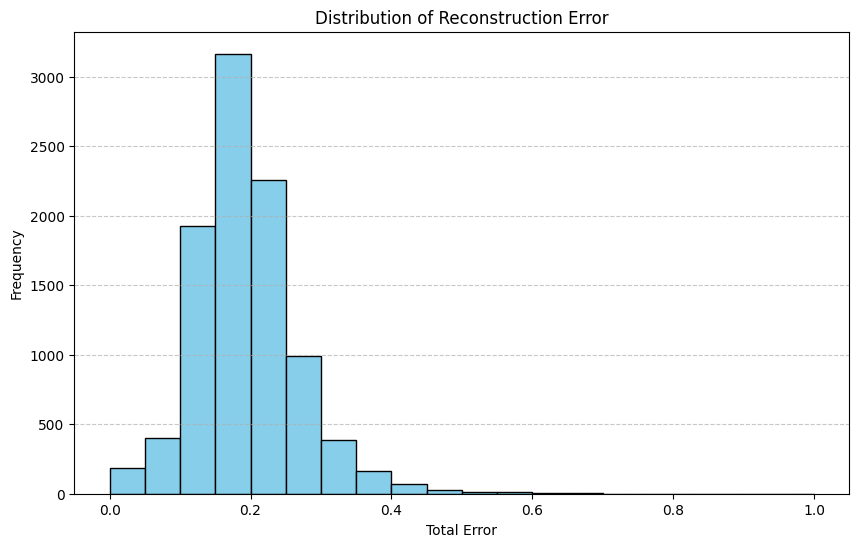

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of the total error
plt.figure(figsize=(10, 6))
plt.hist(merged_df['reconstruction_error'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Reconstruction Error')
plt.xlabel('Total Error')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
bins = [-0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
merged_df['error_class'] = pd.cut(merged_df['reconstruction_error'], bins=bins, labels=labels).cat.codes
merged_df['error_class'].unique()


array([1, 2, 0, 3, 5, 6, 4, 8, 9, 7], dtype=int8)

In [ ]:
# Create the 'binary_error' column based on 'reconstruction_error'
merged_df['binary_error'] = merged_df['reconstruction_error'].apply(lambda x: 0 if x < 0.15 else 1)


In [ ]:
import pandas as pd
from IPython.display import display
from IPython.core.display import HTML

# Calculate the average reconstruction error for each compound name
average_reconstruction_error = merged_df.groupby('Compound Name')['reconstruction_error'].mean()

# Create a DataFrame for better formatting
summary_df = average_reconstruction_error.reset_index()
summary_df.columns = ['Compound Name', 'Average Reconstruction Error']

# Convert the DataFrame to an HTML table with scrolling enabled
scrollable_html = (
    summary_df.style.set_table_styles([
        {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
        {'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px'), ('text-align', 'left')]}
    ])
    .set_properties(**{'white-space': 'nowrap'})
    .to_html()
)

scrollable_html = f"""
<div style="max-height: 400px; overflow-y: scroll; border: 1px solid black; padding: 10px;">
    {scrollable_html}
</div>
"""

# Display the scrollable HTML
display(HTML(scrollable_html))


,Compound Name,Average Reconstruction Error
0,"( R)-(+)-WIN 55,212-2 mesylate[(R)-(+)-[2,3-Dihydro-5-methyl-3[(morpholinyl)methyl]pyrrolo[1,2,3-de]-1,4-benzoxazinyl]-(]",0.115029
1,(+)-isocorydine,0.249832
2,"(-)-[3R,4S]-Chromanol 293B",0.260294
3,(3Z)-3-Benzylidene-4-oxopentanoic acid,0.187289
4,(R)-angolensin,0.208373
5,(S)-(+)-Dimethindene maleate,0.214406
6,(S)-(-)-Pindolol,0.195180
7,"1,3,5-trimethoxybenzene",0.198004
8,"1,5-isoquinolinediol",0.204496
9,"1-(1,3-BENZODIOXOL-5-YLCARBONYL)PIPERIDINE",0.230761


# FNN

In [ ]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 18.3 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

# Import required modules
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Descriptors

# Define functional groups with SMARTS patterns
functional_groups = {
    "Hydroxyl (-OH)": "[OX2H]",
    "Amine (-NH2/-NHR/-NR2)": "[NX3;H2,H1;!$(NC=O)]",
    "Carboxylic Acid (-COOH)": "C(=O)[OX2H1]",
    "Ketone (C=O)": "[CX3](=O)[#6]",
    "Aldehyde (CHO)": "[CX3H1](=O)[#6]",
    "Ester (-COOR)": "C(=O)O[#6]",
    "Ether (-O-)": "[#6]-O-[#6]",
    "Halide (Cl/Br/F/I)": "[F,Cl,Br,I]",
    "Thiol (-SH)": "[SX2H]",
    "Sulfonyl (-SO2-)": "[SX4](=O)(=O)",
    "Aromatic ring": "[a]",
    "Alcohol Group": "[OX2H]",
    "Alkyne": "[CX2]#C",
    "Alkene": "[CX3]=[CX3]",
    "Epoxide": "C1OC1",
    "Amide": "C(=O)N"
}

# Validate SMARTS patterns
print("Validating SMARTS patterns...")
for group_name, smarts in functional_groups.items():
    try:
        pattern = Chem.MolFromSmarts(smarts)
        if pattern is None:
            print(f"Invalid SMARTS: {group_name} -> {smarts}")
        else:
            print(f"Valid SMARTS: {group_name}")
    except Exception as e:
        print(f"Error in SMARTS {group_name}: {e}")

# Function to add features to the DataFrame
def add_features(df, smiles_column):
    for group_name, smarts in functional_groups.items():
        df[group_name] = 0
        pattern = Chem.MolFromSmarts(smarts)
        if not pattern:
            print(f"Skipping invalid SMARTS pattern: {group_name}")
            continue
        for index, row in df.iterrows():
            smiles = row[smiles_column]
            mol = Chem.MolFromSmiles(smiles)
            if mol and mol.HasSubstructMatch(pattern):
                df.at[index, group_name] = 1

    # Add additional features
    for index, row in df.iterrows():
        smiles = row[smiles_column]
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Number of rings
            df.at[index, "Number of Rings"] = rdMolDescriptors.CalcNumRings(mol)
            # Carbon percentage
            carbon_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'C')
            total_atoms = mol.GetNumAtoms()
            df.at[index, "Carbon Percentage"] = (carbon_count / total_atoms) * 100 if total_atoms > 0 else 0
            # Polarity (TPSA)
            df.at[index, "Polarity (TPSA)"] = Descriptors.TPSA(mol)
            # Chirality
            df.at[index, "Chirality"] = sum(1 for atom in mol.GetAtoms() if atom.HasProp('_CIPCode'))
            # Metal presence
            metals = ["Li", "Na", "K", "Rb", "Cs", "Mg", "Ca", "Sr", "Ba", "Al", "Ti", "V", "Cr", "Mn", "Fe",
                      "Co", "Ni", "Cu", "Zn", "Zr", "Mo", "Pd", "Ag", "Cd", "Sn", "Pt", "Au", "Hg", "Pb"]
            df.at[index, "Metal"] = any(atom.GetSymbol() in metals for atom in mol.GetAtoms())
            # Solubility (logP)
            df.at[index, "Solubility (logP)"] = Descriptors.MolLogP(mol)
            # pH (presence of acidic and basic functional groups)
            acidic_groups = Chem.MolFromSmarts("[CX3](=O)[OX2H1]")
            basic_groups = Chem.MolFromSmarts("[NX3;H2,H1;!$(NC=O)]")
            df.at[index, "Acidic Groups"] = mol.HasSubstructMatch(acidic_groups)
            df.at[index, "Basic Groups"] = mol.HasSubstructMatch(basic_groups)
            # Number of double bonds
            df.at[index, "Number of Double Bonds"] = sum(1 for bond in mol.GetBonds() if bond.GetBondTypeAsDouble() == 2)
            # Number of triple bonds
            df.at[index, "Number of Triple Bonds"] = sum(1 for bond in mol.GetBonds() if bond.GetBondTypeAsDouble() == 3)
            # Number of covalent bonds
            df.at[index, "Number of Covalent Bonds"] = mol.GetNumBonds()
            # Number of different atoms
            df.at[index, "Number of Different Atoms"] = len(set(atom.GetSymbol() for atom in mol.GetAtoms()))
            # Number of hydrogen bond donors
            df.at[index, "Hydrogen Bond Donors"] = rdMolDescriptors.CalcNumHBD(mol)
            # Number of hydrogen bond acceptors
            df.at[index, "Hydrogen Bond Acceptors"] = rdMolDescriptors.CalcNumHBA(mol)

    return df



Validating SMARTS patterns...
Valid SMARTS: Hydroxyl (-OH)
Valid SMARTS: Amine (-NH2/-NHR/-NR2)
Valid SMARTS: Carboxylic Acid (-COOH)
Valid SMARTS: Ketone (C=O)
Valid SMARTS: Aldehyde (CHO)
Valid SMARTS: Ester (-COOR)
Valid SMARTS: Ether (-O-)
Valid SMARTS: Halide (Cl/Br/F/I)
Valid SMARTS: Thiol (-SH)
Valid SMARTS: Sulfonyl (-SO2-)
Valid SMARTS: Aromatic ring
Valid SMARTS: Alcohol Group
Valid SMARTS: Alkyne
Valid SMARTS: Alkene
Valid SMARTS: Epoxide
Valid SMARTS: Amide


In [ ]:
merged_df_copy = merged_df.copy()
add_features(merged_df, "Compound SMILES")

,Plate ID,Image Name,Red Brightness,Green Brightness,Blue Brightness,Image Array,Total Brightness,Plate,Well,Well Number,...,Metal,Solubility (logP),Acidic Groups,Basic Groups,Number of Double Bonds,Number of Triple Bonds,Number of Covalent Bonds,Number of Different Atoms,Hydrogen Bond Donors,Hydrogen Bond Acceptors
0,6208,"24277 [Well A1, Field 2]",30.582893,28.410065,14.621919,"[[[17, 12, 6], [17, 12, 6], [20, 17, 8], [26, ...",73.614877,24277,A1,1,...,False,2.55620,False,True,1.0,0.0,21.0,3.0,1.0,5.0
1,6208,"24277 [Well A2, Field 2]",54.596978,36.532570,20.970217,"[[[34, 17, 0], [31, 12, 0], [37, 12, 7], [53, ...",112.099765,24277,A2,2,...,False,5.02822,False,False,2.0,0.0,22.0,2.0,0.0,2.0
2,6208,"24277 [Well A3, Field 2]",38.505135,41.843016,15.798415,"[[[0, 31, 0], [7, 38, 7], [23, 47, 34], [34, 5...",96.146567,24277,A3,3,...,False,3.57120,False,False,1.0,0.0,18.0,2.0,1.0,2.0
3,6208,"24277 [Well A4, Field 2]",22.289466,26.241491,14.119425,"[[[80, 24, 25], [98, 47, 46], [69, 28, 24], [3...",62.650381,24277,A4,4,...,False,-1.20060,False,False,1.0,0.0,25.0,2.0,5.0,9.0
4,6208,"24277 [Well A5, Field 2]",20.238263,24.889965,22.041520,"[[[5, 8, 0], [6, 10, 0], [3, 13, 2], [3, 15, 1...",67.169748,24277,A5,5,...,False,2.48380,True,False,3.0,0.0,32.0,4.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,6210,"24293 [Well P20, Field 6]",35.164173,30.226819,19.706573,"[[[20, 5, 10], [20, 7, 16], [23, 12, 26], [26,...",85.097565,24293,P20,380,...,False,3.51102,False,False,1.0,0.0,17.0,3.0,1.0,4.0
9596,6210,"24293 [Well P21, Field 6]",34.876320,52.937353,27.894806,"[[[24, 51, 20], [32, 61, 31], [41, 73, 50], [3...",115.708480,24293,P21,381,...,False,1.77450,False,False,1.0,0.0,12.0,4.0,1.0,2.0
9597,6210,"24293 [Well P22, Field 6]",26.382189,40.200558,14.141725,"[[[27, 29, 15], [20, 23, 6], [14, 18, 0], [12,...",80.724472,24293,P22,382,...,False,3.09280,False,False,1.0,0.0,21.0,2.0,2.0,4.0
9598,6210,"24293 [Well P23, Field 6]",30.207600,30.315434,13.399501,"[[[51, 61, 36], [77, 82, 59], [77, 70, 51], [4...",73.922535,24293,P23,383,...,False,-0.06870,False,False,3.0,0.0,9.0,3.0,0.0,2.0


In [ ]:
merged_df_copy['dose_numeric'] = merged_df_copy['Dose'].str.extract('(\d+\.\d+)').astype(float)

In [ ]:
# Convert NaN values in the 'dose_numeric' column to 0
merged_df_copy['dose_numeric'] = merged_df_copy['dose_numeric'].fillna(0)

In [ ]:
merged_df_copy.columns

Index(['Plate ID', 'Image Name', 'Red Brightness', 'Green Brightness',
       'Blue Brightness', 'Image Array', 'Total Brightness', 'Plate', 'Well',
       'Well Number', 'Characteristics [Organism]', 'Term Source 1 REF',
       'Term Source 1 Accession', 'Characteristics [Cell Line]',
       'Term Source 2 REF', 'Term Source 2 Accession',
       'Compound Broad Identifier', 'Compound Broad Identifier Short',
       'Compound Name', 'Compound Group',
       'Compound Broad Identifier_Compound Group', 'Compound Source',
       'Vendor Catalog Identifier', 'Compound SMILES', 'PubChem InChIKey',
       'Dose', 'Control Type', 'Control Comments', 'Channels', 'Comments',
       'Plate Issues', 'red_change', 'blue_change', 'green_change',
       'total_change', 'red_sign', 'blue_sign', 'green_sign', 'total_sign',
       'total_change_label', 'reconstruction_error', 'error_class',
       'binary_error', 'Hydroxyl (-OH)', 'Amine (-NH2/-NHR/-NR2)',
       'Carboxylic Acid (-COOH)', 'Ketone (C=O

In [ ]:
#define features and labels
feature_columns = [
    'reconstruction_error', 'error_class', 'binary_error', 'Hydroxyl (-OH)',
       'Amine (-NH2/-NHR/-NR2)', 'Carboxylic Acid (-COOH)', 'Ketone (C=O)',
       'Aldehyde (CHO)', 'Ester (-COOR)', 'Ether (-O-)', 'Halide (Cl/Br/F/I)',
       'Thiol (-SH)', 'Sulfonyl (-SO2-)', 'Aromatic ring', 'Number of Rings',
       'Carbon Percentage', 'Polarity (TPSA)', 'Chirality',
       'Solubility (logP)', 'Acidic Groups', 'Basic Groups', 'Alcohol Group',
       'Alkyne', 'Alkene', 'Epoxide', 'Amide', 'Number of Double Bonds',
       'Number of Triple Bonds', 'Number of Covalent Bonds',
       'Number of Different Atoms', 'Hydrogen Bond Donors',
       'Hydrogen Bond Acceptors', 'dose_numeric'
]


features = np.array(merged_df_copy[feature_columns])

reg_labels = np.array(merged_df_copy['reconstruction_error'].values)

class_labels = merged_df_copy['error_class'].values
class_labels = np.array(class_labels)

binary_labels = merged_df_copy['binary_error'].values
binary_labels = np.array(binary_labels)





In [ ]:
dose_df = merged_df_copy[['error_class', 'Hydroxyl (-OH)',
       'Amine (-NH2/-NHR/-NR2)', 'Carboxylic Acid (-COOH)', 'Ketone (C=O)',
       'Aldehyde (CHO)', 'Ester (-COOR)', 'Ether (-O-)', 'Halide (Cl/Br/F/I)',
       'Thiol (-SH)', 'Sulfonyl (-SO2-)', 'Aromatic ring', 'Number of Rings',
       'Carbon Percentage', 'Polarity (TPSA)', 'Chirality',
       'Solubility (logP)', 'Acidic Groups', 'Basic Groups', 'Alcohol Group',
        'Alkene', 'Epoxide', 'Amide', 'Number of Double Bonds',
       'Number of Triple Bonds', 'Number of Covalent Bonds',
       'Number of Different Atoms', 'Hydrogen Bond Donors',
       'Hydrogen Bond Acceptors', 'dose_numeric']]
dose_df.corr()

,error_class,Hydroxyl (-OH),Amine (-NH2/-NHR/-NR2),Carboxylic Acid (-COOH),Ketone (C=O),Aldehyde (CHO),Ester (-COOR),Ether (-O-),Halide (Cl/Br/F/I),Thiol (-SH),...,Alkene,Epoxide,Amide,Number of Double Bonds,Number of Triple Bonds,Number of Covalent Bonds,Number of Different Atoms,Hydrogen Bond Donors,Hydrogen Bond Acceptors,dose_numeric
error_class,1.000000,-0.055574,-0.018963,0.007562,-0.053898,-0.031884,-0.072981,-0.062054,0.016853,-0.057835,...,-0.053035,-0.025177,-0.027389,-0.051685,-0.021839,-0.081566,0.007671,-0.075212,-0.087025,-0.066403
Hydroxyl (-OH),-0.055574,1.000000,-0.031825,0.497080,0.381128,0.051617,0.044557,0.059507,-0.047068,-0.033490,...,0.194489,0.112646,-0.031130,0.235461,0.037623,0.329389,-0.139554,0.543126,0.274886,0.149390
Amine (-NH2/-NHR/-NR2),-0.018963,-0.031825,1.000000,0.023400,-0.110351,-0.054309,-0.078951,-0.042929,0.141491,-0.020778,...,-0.130152,-0.037546,-0.046704,-0.067578,-0.010113,0.057467,0.185459,0.381895,0.172259,0.191872
Carboxylic Acid (-COOH),0.007562,0.497080,0.023400,1.000000,0.401102,-0.016008,-0.020260,-0.002466,-0.003479,-0.016647,...,0.036944,-0.030082,0.057898,0.278451,-0.058084,0.142649,-0.017959,0.254408,0.040805,0.014509
Ketone (C=O),-0.053898,0.381128,-0.110351,0.401102,1.000000,0.131478,0.320284,0.240534,0.039288,-0.041503,...,0.271965,0.090896,0.463565,0.525793,-0.023157,0.449130,0.004505,0.306126,0.281017,0.184187
Aldehyde (CHO),-0.031884,0.051617,-0.054309,-0.016008,0.131478,1.000000,0.078200,0.110741,-0.057077,-0.005457,...,0.028935,-0.009861,-0.020396,0.066045,-0.021313,0.026319,-0.135721,0.041774,0.055906,0.065633
Ester (-COOR),-0.072981,0.044557,-0.078951,-0.020260,0.320284,0.078200,1.000000,0.484951,-0.090330,-0.016898,...,0.183971,0.145167,0.052160,0.220904,-0.059140,0.184301,-0.109329,0.002317,0.251496,0.085552
Ether (-O-),-0.062054,0.059507,-0.042929,-0.002466,0.240534,0.110741,0.484951,1.000000,-0.047953,-0.034844,...,0.078842,0.108269,0.019760,0.077865,-0.071322,0.409313,-0.057066,-0.000981,0.433695,0.193682
Halide (Cl/Br/F/I),0.016853,-0.047068,0.141491,-0.003479,0.039288,-0.057077,-0.090330,-0.047953,1.000000,-0.021837,...,-0.040918,-0.039459,0.109799,-0.011766,-0.062354,0.245416,0.601752,0.090191,0.069295,0.178026
Thiol (-SH),-0.057835,-0.033490,-0.020778,-0.016647,-0.041503,-0.005457,-0.016898,-0.034844,-0.021837,1.000000,...,-0.022808,-0.003772,-0.024177,-0.019281,-0.008154,-0.052144,-0.002765,-0.004900,-0.053405,0.015995


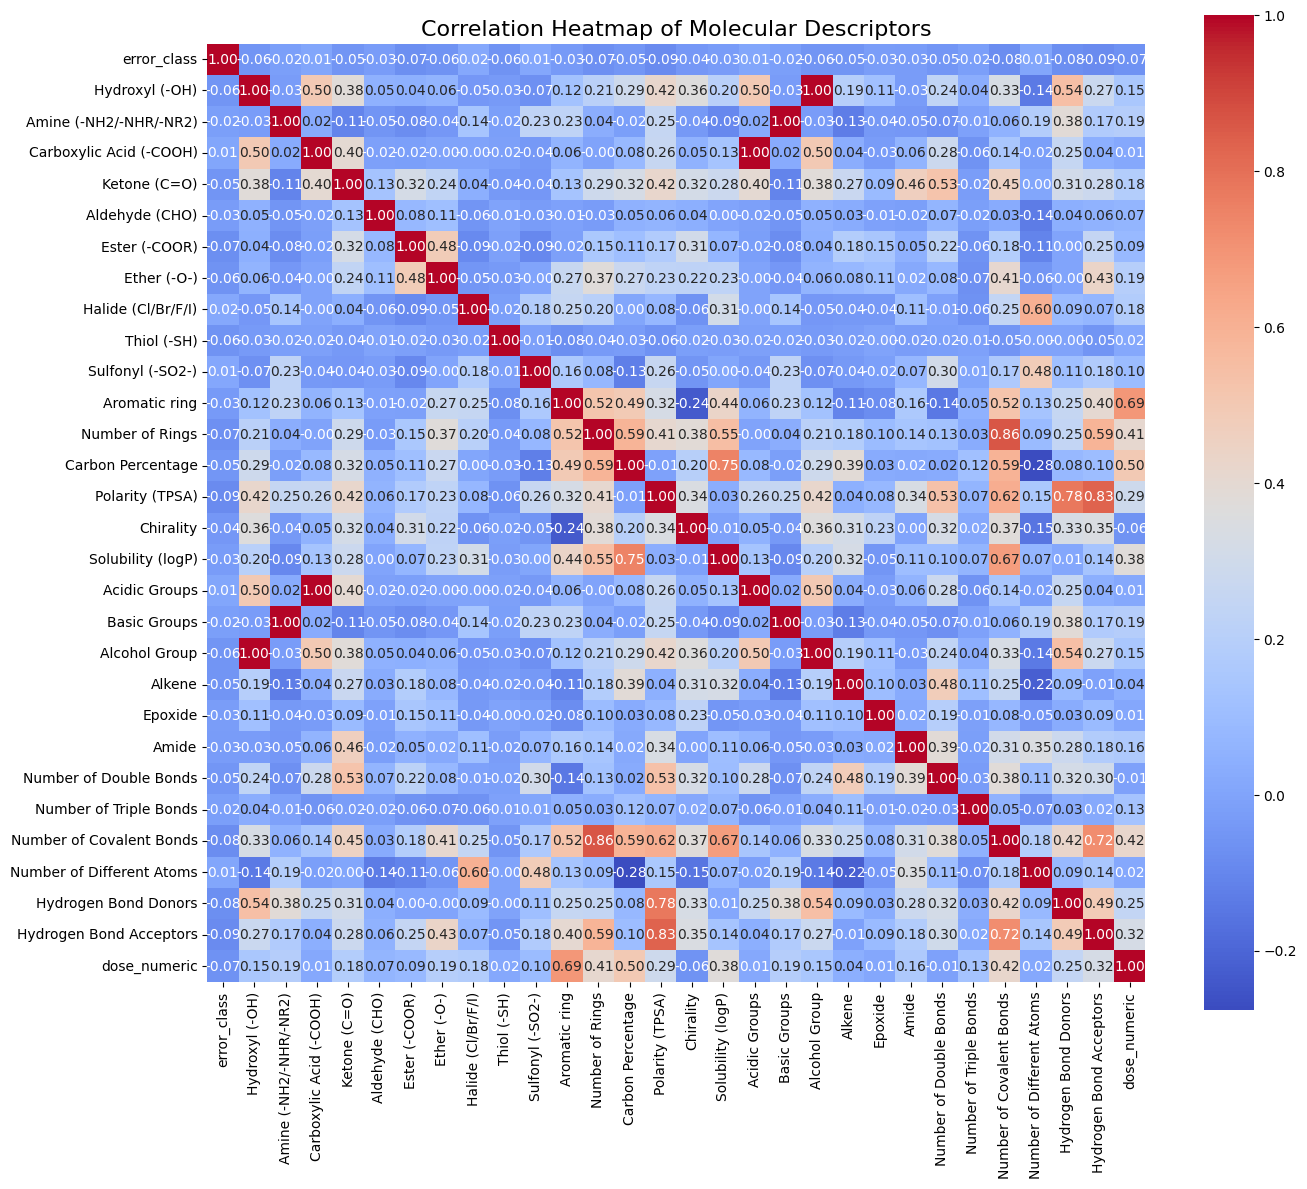

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix
correlation_matrix = dose_df.corr()

# Create a correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True
)

# Add a title
plt.title("Correlation Heatmap of Molecular Descriptors", fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
#best model
#fnn classification model using 10 classifications of relative toxicity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.metrics import AUC
from collections import Counter


y = class_labels

# Convert the target labels to one-hot encoding (class labels between 0 and 9)
y_class = tf.keras.utils.to_categorical(y, num_classes=10)

# Prepare the features and scale them
scaler = StandardScaler()
x_scaled = scaler.fit_transform(features)

# train test split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_class, test_size=0.2, random_state=42)

# Define the model for classification
#l2 regularization and 0.2 dropout
model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# Compile the model with Adam optimizer and AUC metric
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC()])

# Train the model
#use class weights to rectify class imbalance
class_counts = Counter(y)
total_samples = sum(class_counts.values())

# Calculate weights inversely proportional to frequencies
class_weights = {k: total_samples / v for k, v in class_counts.items()}

# Normalize weights
min_weight = min(class_weights.values())
normalized_class_weights = {k: v / min_weight for k, v in class_weights.items()}

#fit model on train data
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), class_weight=normalized_class_weights, verbose=1)


# Evaluate the model on the test set
y_test_pred = model.predict(x_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)  # Convert probabilities to class labels
y_test_true_classes = np.argmax(y_test, axis=1)  # True class labels

# Calculate metrics
test_loss, test_accuracy, test_auc = model.evaluate(x_test, y_test, verbose=0)
precision = precision_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=1)
recall = recall_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=1)
f1 = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=1)

# Print performance metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2617 - auc: 0.7680 - loss: 14.9056 - val_accuracy: 0.5188 - val_auc: 0.9302 - val_loss: 2.2042
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4958 - auc: 0.9202 - loss: 12.8219 - val_accuracy: 0.7125 - val_auc: 0.9606 - val_loss: 1.8931
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6112 - auc: 0.9502 - loss: 9.8246 - val_accuracy: 0.8260 - val_auc: 0.9851 - val_loss: 1.5948
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7258 - auc: 0.9706 - loss: 15.0394 - val_accuracy: 0.8339 - val_auc: 0.9874 - val_loss: 1.4926
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7708 - auc: 0.9782 - loss: 5.7833 - val_accuracy: 0.9432 - val_auc: 0.9976 - val_loss: 1.2995
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8053 - auc: 0.9849 - loss: 6.2899 - val_accuracy: 0.9505 - val_auc: 0.9982 - val_loss: 1.2560
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━

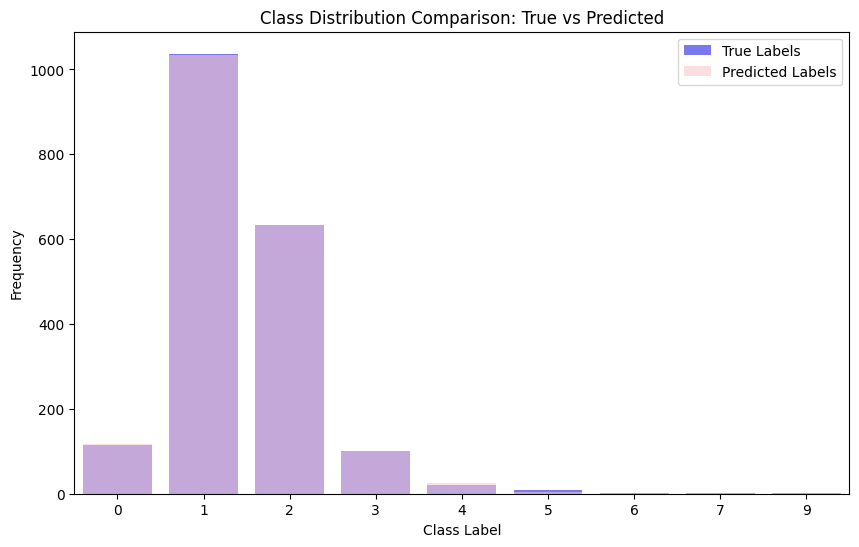

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of true and predicted labels
plt.figure(figsize=(10, 6))
sns.countplot(x=y_test_true_classes, label='True Labels', color='blue', alpha=0.6)
sns.countplot(x=y_test_pred_classes, label='Predicted Labels', color='pink', alpha=0.6)

plt.legend()
plt.title('Class Distribution Comparison: True vs Predicted')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.show()






In [ ]:
# Check the class distribution
class_counts = pd.Series(class_labels).value_counts()

print(class_counts)


1    5089
2    3246
0     586
3     552
4      91
5      24
6       6
8       2
9       2
7       2
Name: count, dtype: int64


# **Explore The Data**

Below, we explore the contents of the directory of zipped files to ensure they are extracted properly. The code below will print the first three files from each directory in the unzipped_data folder.

In [ ]:
# unzip_dir = "/content/unzipped_data"

# # extracted directories and files
# for root, dirs, files in os.walk(unzip_dir):
#     print(f"Directory: {root}")
#     for file in files[:3]:  # Print the first 3 files of each directory
#         print(f"  {file}")


Below, we will explore whether the images were downloaded and extracted correctly. The code below will display one random image from each subdirectory in the unzipped_data folder.

In [ ]:
# # Loop through each subdirectory
# for subdir in sorted(os.listdir(unzip_dir)):
#     subdir_path = os.path.join(unzip_dir, subdir)

#     if os.path.isdir(subdir_path):
#         files = os.listdir(subdir_path)

#         # Choose one random file
#         if files:
#             random_file = random.choice(files)
#             random_file_path = os.path.join(subdir_path, random_file)

#             image = cv2.imread(random_file_path, cv2.IMREAD_COLOR)

#             if image is not None:
#                 # Need to convert from BGR to RGB for matplotlib
#                 plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#                 plt.title(f"Random Image from {subdir}")
#                 plt.axis("off")
#                 plt.show()
#             else:
#                 print(f"Error: Unable to read image: {random_file_path}")
#         else:
#             print(f"No files found in directory: {subdir_path}")



**THE BELOW CODE CONVERTS .TIFF FILES TO .NPZ AND COMPRESSES FOR DOWNLOAD**  
**WILL NOT BE USED IN FINAL SUBMISSION**

In [ ]:
# # Ben 11/23 1 pm

# ### !!!!!!!!!!WARNING!!!!!!!!! ###
# # Running this cell takes a while (>20 min)
# # Just download data_numpy.zip - it contains all the images saved as .npz

# # This cell takes 1 min for 1 Folder (i.e. 24277-ERSyto)
# # Convert tif files to numpy to save space.

# from tifffile import imread

# def convert_tif_to_npz(input_dir, output_dir, target_size=(224, 224)):
#     """
#     Converts .tif files to .npz format with normalized pixel values and resized dimensions.

#     Parameters:
#         input_dir (str): Directory containing .tif files.
#         output_dir (str): Directory to save the .npz files.
#         target_size (tuple): Target size (height, width) for resizing the images.
#     """
#     os.makedirs(output_dir, exist_ok=True)
#     for file_name in os.listdir(input_dir):
#         if file_name.endswith(".tif"):
#             # Read the .tif image
#             file_path = os.path.join(input_dir, file_name)
#             image = imread(file_path)

#             # Normalize pixel values to [0, 1]
#             image = (image - image.min()) / (image.max() - image.min())

#             # Resize the image to the target size
#             resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

#             # Save as .npz (compressed NumPy array)
#             output_path = os.path.join(output_dir, file_name.replace(".tif", ".npz"))
#             np.savez_compressed(output_path, image=resized_image)

#             # Optional: Print confirmation for each file
#             # print(f"Processed and saved: {output_path}")

# # Process all subfolders in "unzipped_data"
# base_input_dir = "/content/unzipped_data"
# base_output_dir = "/content/data_numpy"

# for folder_name in os.listdir(base_input_dir):
#     folder_path = os.path.join(base_input_dir, folder_name)

#     # Check if it's a directory
#     if os.path.isdir(folder_path):
#         # Create corresponding output directory
#         output_folder = os.path.join(base_output_dir, folder_name)
#         print(f"Processing folder: {folder_name}")

#         # Call the function for each folder
#         convert_tif_to_npz(input_dir=folder_path, output_dir=output_folder, target_size=(224, 224))

In [ ]:
# def show_random_images(folder_path, num_images=10):
#     """
#     Display a random selection of images from a folder containing .npz files.

#     Parameters:
#         folder_path (str): Path to the folder containing .npz files.
#         num_images (int): Number of images to display.
#     """
#     # List all .npz files in the folder
#     npz_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]

#     # Randomly select files
#     selected_files = random.sample(npz_files, num_images)

#     # Display each image

#     for i, file_name in enumerate(selected_files, 1):
#         file_path = os.path.join(folder_path, file_name)

#         # Load the .npz file
#         with np.load(file_path) as data:
#             image = data['image']  # Replace 'image' with the correct key if needed

#         # Plot the imageb
#         plt.figure(figsize=(3, 3))
#         plt.imshow(image)
#         plt.title(f"Image {i}: {file_name}")
#         plt.axis("off")
#         plt.show()

# # Example usage
# show_random_images(folder_path="/content/data_numpy/24277-ERSyto", num_images=2)

In [ ]:
# ### Ben 11/23 5 pm ###
# # !!!!!!!!!!!!!DON'T RUN !!!!!!!!!!!!!!! #
# # !!!!!TAKES FOREVER (20 min)!!!!!!!!!!! #
# # This is to make the .zip file for all the numpy arrays.
# # JUST DOWNLOAD data_numpy.zip FROM THE GOOGLE DRIVE

# import shutil

# # Path to the folder containing subfolders to compress
# folder_to_zip = "/content/data_numpy"

# # Output zip file name
# zip_file_name = "/content/data_numpy.zip"
# # Compress the folder and all its contents
# shutil.make_archive(base_name=zip_file_name.replace('.zip', ''), format='zip', root_dir=folder_to_zip)

# print(f"All folders in '{folder_to_zip}' have been compressed into: {zip_file_name}")

In [ ]:
# shutil.rmtree('/content/unzipped_data')

**FUNCTION TO SCRAPE ALL IMAGES FOR A GIVEN COMPOUND**

In [ ]:
# # BEN 11/24

# PLATES_URL = "https://idr.openmicroscopy.org/webclient/api/plates/?id={screen_id}"

# # We need to access the plates by id. We can extract this here.
# plate_number_plate_id = {}
# qs = {'screen_id': screen_id}
# url = PLATES_URL.format(**qs)
# for p in session.get(url).json()['plates']:
#     plate_id = p['id']
#     plate_number_plate_id[p['name']] = p['id']
#     # print (p['id'], p['name'], p['childCount'])

# def get_plate_num_and_wells(compound, annotations):
#     """Get all the plates and wells where a particular compound appears"""
#     df = annotations[annotations['Compound Name'] == compound][['Plate', 'Well Number']]
#     dict = df.groupby('Plate')['Well Number'].apply(list).to_dict()
#     return dict

# def fetch_images_for_compound(compound, session, annotations, plate_number_plate_id):
#     """Stores images in a numpy array for a given compound."""
#     BASE_URL = "https://idr.openmicroscopy.org"
#     FIELD = 1  # Define this as a parameter if needed

#     # Get plate numbers and wells associated with the given compound
#     plate_and_well_num = get_plate_num_and_wells(compound, annotations)

#     # Total images to allocate array size
#     num_images = annotations['Compound Name'].value_counts().get(compound, 0)
#     if num_images == 0:
#         raise ValueError(f"No images found for compound: {compound}")

#     images = np.zeros((num_images, 71, 96, 3))  # Adjust dimensions if needed

#     index = 0  # To track images in the array
#     for plate_number, wells in plate_and_well_num.items():
#         print(f"Processing plate: {plate_number}")
#         plate_id = plate_number_plate_id.get(str(plate_number))
#         if not plate_id:
#             print(f"Plate ID not found for plate number: {plate_number}")
#             continue

#         WELLS_IMAGES_URL = f"{BASE_URL}/webgateway/plate/{plate_id}/{FIELD - 1}/"
#         try:
#             response = session.get(WELLS_IMAGES_URL)
#             response.raise_for_status()
#             grid = response.json()
#         except Exception as e:
#             print(f"Error fetching grid for plate {plate_id}: {e}")
#             continue

#         well_num = 0
#         # Process the grid to fetch images
#         for row in grid['grid']:
#             for cell in row:
#                 well_num += 1
#                 if cell is not None and well_num in wells:
#                     print(f"Retreiving image from cell {well_num} in plate {plate_number}")
#                     thumb_url = BASE_URL + cell['thumb_url']
#                     try:
#                         image_response = session.get(thumb_url)
#                         image_response.raise_for_status()
#                         img = Image.open(BytesIO(image_response.content))
#                         image_array = np.array(img)
#                         if image_array.shape == (71, 96, 3):  # Validate shape
#                             images[index] = image_array / 255.0  # Normalize
#                             index += 1
#                         else:
#                             print(f"Unexpected image shape: {image_array.shape} for {thumb_url}")
#                     except Exception as e:
#                         print(f"Error processing image from {thumb_url}: {e}")

#     if index == 0:
#         print("No images were successfully processed.")
#     return images[:index]  # Slice in case fewer images are processed


# # Example usage of fetch_images_for_compound().
# # Clone the repository at https://github.com/IDR/idr0016-wawer-bioactivecompoundprofiling/blob/HEAD/screenA/idr0016-screenA-annotation.csv
# # to get the .csv file
# # annotations = pd.read_csv("./idr0016-wawer-bioactivecompoundprofiling\screenA\idr0016-screenA-annotation.csv")

# with requests.Session() as session:
#     compound = 'anabasine'
#     anabasine_info = well_annotations[well_annotations['Compound Name'] == compound][['Plate','Well', 'Well Number', 'Compound Name', 'Channels']]
#     anabasine_images = fetch_images_for_compound(compound, session, well_annotations, plate_number_plate_id)

# RDKIT

In [ ]:
# import pandas as pd

# csv_file_path = "idr0016-screenA-annotation.csv"

# required_columns = ["Plate", "Well", "Compound SMILES"]

# try:
#     Compound_SMILES_df = pd.read_csv(csv_file_path, usecols=required_columns)
#     print("Compound SMILES DataFrame created successfully!")

#     # Display the first few rows
#     print(Compound_SMILES_df.head())

# except ValueError as ve:
#     print(f"Some of the required columns are missing in the CSV: {ve}")
# except Exception as e:
#     print(f"Error occurred: {e}")

In [ ]:
# !pip install rdkit-pypi

In [ ]:
# import re

# nan_count = Compound_SMILES_df['Compound SMILES'].isna().sum()
# print(f"Number of NaN values in the column: {nan_count}")


# data = Compound_SMILES_df.copy()
# # Replace any string 'nan' with a proper NaN value
# data["Compound SMILES"] = data["Compound SMILES"].replace("nan", pd.NA)
# data["Compound SMILES"] = data["Compound SMILES"].fillna("None")

# # To strippe of whitespace and hidden characters
# data["Compound SMILES"] = data["Compound SMILES"].apply(
#     lambda x: re.sub(r"[^\x20-\x7E]", "", x.strip()) if isinstance(x, str) else x
# )

In [ ]:
# from rdkit import Chem

# functional_groups = {
#     "Hydroxyl (-OH)": "[OX2H]",
#     "Amine (-NH2/-NHR/-NR2)": "[NX3;H2,H1;!$(NC=O)]",
#     "Carboxylic Acid (-COOH)": "C(=O)[OX2H1]",
#     "Ketone (C=O)": "[CX3](=O)[#6]",
#     "Aldehyde (CHO)": "[CX3H1](=O)[#6]",
#     "Ester (-COOR)": "C(=O)O[#6]",
#     "Ether (-O-)": "[#6]-O-[#6]",
#     "Halide (Cl/Br/F/I)": "[F,Cl,Br,I]",
#     "Thiol (-SH)": "[SX2H]",
#     "Sulfonyl (-SO2-)": "[SX4](=O)(=O)",
#     "Aromatic ring": "[a]"
# }

# print("Validating SMARTS patterns...")
# for group_name, smarts in functional_groups.items():
#     try:
#         pattern = Chem.MolFromSmarts(smarts)
#         if pattern is None:
#             print(f"Invalid SMARTS: {group_name} -> {smarts}")
#         else:
#             print(f"Valid SMARTS: {group_name}")
#     except Exception as e:
#         print(f"Error in SMARTS {group_name}: {e}")


# # A function to extract functional groups
# def extract_functional_groups(smiles):
#     try:
#         mol = Chem.MolFromSmiles(smiles)
#         if not mol:
#             print(f"Invalid SMILES detected: {smiles}")
#             return "Invalid SMILES"
#         found_groups = []
#         for group_name, smarts in functional_groups.items():
#             pattern = Chem.MolFromSmarts(smarts)
#             if pattern is None:
#                 print(f"Skipping invalid SMARTS pattern: {group_name}")
#                 continue
#             if mol.HasSubstructMatch(pattern):
#                 found_groups.append(group_name)
#         return ", ".join(found_groups) if found_groups else "No functional groups found"
#     except Exception as e:
#         print(f"Error processing SMILES '{smiles}': {e}")
#         return f"Error processing SMILES: {e}"

# # Replace 'nan' strings with None and handle NaN values
# #data["Compound SMILES"] = data["Compound SMILES"].replace("nan", pd.NA)
# #data["Compound SMILES"] = data["Compound SMILES"].fillna("None")

# for index, row in data.iterrows():
#     smiles = row["Compound SMILES"]
#     plate = row["Plate"]
#     well = row["Well"]
#     if smiles == "None":
#         data.at[index, "Functional Groups"] = "No functional groups (SMILES is None)"
#     else:
#         result = extract_functional_groups(smiles)
#         data.at[index, "Functional Groups"] = result

# print("Functional groups extracted.")

# # Save the processed data for the sample
# #data_sample.to_csv("processed_smiles_sample_with_corrected_sulfur_groups.csv", index=False)

In [ ]:
# data.head()